In [1]:
# prepare packages
import tensorflow as tf
import numpy as np
#import pickle as pkl
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

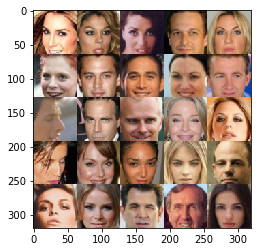

In [2]:
# get data sets
import os
from glob import glob
import helper
dataset_dir = '../Data_sets/'
test_images = helper.get_batch(glob(os.path.join(dataset_dir, 'img_align_celeba/*.jpg'))[:25], 64, 64, 'RGB')
plt.imshow(helper.images_square_grid(test_images, 'RGB'))

# Network

In [3]:
# input placeholders
def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    
    return inputs_real, inputs_z

In [4]:
def generator(z, output_dim, reuse=False, initial_feature_size=1024, alpha=0.2, is_training=True):
    with tf.variable_scope('generator', reuse=reuse):        
        # try different weight initializer
        # w_init = tf.contrib.layers.variance_scaling_initializer()
        # w_init = tf.truncated_normal_initializer(stddev=0.02)
        w_init = tf.contrib.layers.xavier_initializer()
        
        # 1. Fully connected layer (make 4x4x512) & reshape to prepare first layer
        feature_map_size = initial_feature_size
        x1 = tf.layers.dense(inputs=z, 
                             units=4*4*feature_map_size, 
                             activation=None, 
                             use_bias=True, 
                             kernel_initializer=w_init)
        x1 = tf.reshape(tensor=x1, shape=[-1, 4, 4, feature_map_size])
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_training)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. deconvolutional layer (make 8x8x256)
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=feature_map_size, 
                                        kernel_size=5, 
                                        strides=2, 
                                        padding='same', 
                                        activation=None, 
                                        kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. deconvolutional layer (make 16x16x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, 
                                        filters=feature_map_size, 
                                        kernel_size=5, 
                                        strides=2, 
                                        padding='same', 
                                        activation=None, 
                                        kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4. deconvolutional layer (make 32x32x64)
        feature_map_size = feature_map_size // 2
        x4 = tf.layers.conv2d_transpose(inputs=x3, 
                                        filters=feature_map_size, 
                                        kernel_size=5, 
                                        strides=2, 
                                        padding='same', 
                                        activation=None, 
                                        kernel_initializer=w_init)
        x4 = tf.layers.batch_normalization(inputs=x4, training=is_training)
        x4 = tf.maximum(alpha * x4, x4)
        
        # 4. Output layer, 64x64x3
        logits = tf.layers.conv2d_transpose(inputs=x4, 
                                            filters=output_dim, 
                                            kernel_size=5, 
                                            strides=2, 
                                            padding='same', 
                                            activation=None,
                                            kernel_initializer=w_init)
        out = tf.tanh(logits)
    return out

In [5]:
def discriminator(x, reuse=False, initial_filter_size=64, alpha=0.2, is_training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # input is 64x64x3
        
        # try different weight initializer
        # w_init = tf.contrib.layers.variance_scaling_initializer()
        # w_init = tf.truncated_normal_initializer(stddev=0.02)
        w_init = tf.contrib.layers.xavier_initializer()
        
        # 1. make 32x32x64
        filters = initial_filter_size
        x1 = tf.layers.conv2d(inputs=x, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. make 16x16x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. make 8x8x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4. make 4x4x512
        filters = filters * 2
        x4 = tf.layers.conv2d(inputs=x3, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x4 = tf.layers.batch_normalization(inputs=x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        
        # 5. flatten the layer
        flattend_layer = tf.reshape(tensor=x4, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattend_layer, 
                                 units=1, 
                                 activation=None, 
                                 use_bias=True, 
                                 kernel_initializer=w_init)
        out = tf.sigmoid(logits)
    return out, logits

In [6]:
def model_loss(input_real, input_z, output_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_real_label = tf.ones_like(d_logits_real) * (1 - smooth)
    d_fake_label = tf.zeros_like(d_logits_real)
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_label) )
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_label) )
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)) )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

# Build

In [8]:
class DCGAN:
    def __init__(self, data_shape, z_size, learning_rate, alpha=0.2, beta1=0.5, smooth=0.1):
        tf.reset_default_graph()
        
        self.z_size = z_size
        self.input_real, self.input_z = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[3], alpha=alpha, smooth=smooth)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

# Train

In [9]:
# image save function
def save_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, img_str, title):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, is_training=False),
        feed_dict={input_z: example_z})
    
    fig = plt.figure()
    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.suptitle(title)
    plt.savefig(img_str)
    plt.close(fig)

In [10]:
def train(net, epochs, batch_size, get_batches, data_shape, data_image_mode, show_n_images, print_every=10):
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, net.z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
            
            # save generated images on every epochs
            image_fn = './assets/DCGAN-celebA-epoch-{:d}.png'.format(e)
            image_title = 'epoch {:d}'.format(e)
            save_generator_output(sess, show_n_images, net.input_z, data_shape[3], data_image_mode, image_fn, image_title)                    
                    
    return losses

# Hyperparameters

In [11]:
z_size = 100 # 256
learning_rate = 0.0002
batch_size = 128
epochs = 30
alpha = 0.2
beta1 = 0.5
smooth = 0.1
show_n_images = 25

# get data
celebA_dataset = helper.Dataset(glob(os.path.join(dataset_dir, 'img_align_celeba/*.jpg')))

# Create the network
net = DCGAN(celebA_dataset.shape, z_size, learning_rate, alpha=alpha, beta1=beta1, smooth=smooth)

In [12]:
assets_dir = './assets/'
if not os.path.isdir(assets_dir):
    os.mkdir(assets_dir)

In [13]:
losses = train(net, epochs, batch_size, celebA_dataset.get_batches, celebA_dataset.shape, celebA_dataset.image_mode, show_n_images)

Epoch 1/30... Discriminator Loss: 1.1055... Generator Loss: 7.1837
Epoch 1/30... Discriminator Loss: 0.6803... Generator Loss: 14.0241
Epoch 1/30... Discriminator Loss: 2.3243... Generator Loss: 0.4285
Epoch 1/30... Discriminator Loss: 2.2553... Generator Loss: 4.8673
Epoch 1/30... Discriminator Loss: 1.6748... Generator Loss: 0.5234
Epoch 1/30... Discriminator Loss: 1.6730... Generator Loss: 0.6082
Epoch 1/30... Discriminator Loss: 2.2593... Generator Loss: 0.6694
Epoch 1/30... Discriminator Loss: 2.0522... Generator Loss: 0.3745
Epoch 1/30... Discriminator Loss: 1.4944... Generator Loss: 0.7304
Epoch 1/30... Discriminator Loss: 1.5161... Generator Loss: 0.6781
Epoch 1/30... Discriminator Loss: 1.1999... Generator Loss: 1.6670
Epoch 1/30... Discriminator Loss: 1.2451... Generator Loss: 1.0916
Epoch 1/30... Discriminator Loss: 1.0718... Generator Loss: 1.1084
Epoch 1/30... Discriminator Loss: 0.8876... Generator Loss: 1.4992
Epoch 1/30... Discriminator Loss: 1.0262... Generator Loss: 1

Epoch 1/30... Discriminator Loss: 1.1206... Generator Loss: 0.8656
Epoch 1/30... Discriminator Loss: 1.2184... Generator Loss: 1.4327
Epoch 1/30... Discriminator Loss: 1.2469... Generator Loss: 1.2214
Epoch 1/30... Discriminator Loss: 1.1581... Generator Loss: 1.0644
Epoch 1/30... Discriminator Loss: 1.2526... Generator Loss: 0.7866
Epoch 1/30... Discriminator Loss: 1.1145... Generator Loss: 1.2850
Epoch 1/30... Discriminator Loss: 1.1815... Generator Loss: 0.8179
Epoch 1/30... Discriminator Loss: 1.2261... Generator Loss: 1.4174
Epoch 1/30... Discriminator Loss: 1.1066... Generator Loss: 1.0077
Epoch 1/30... Discriminator Loss: 1.2826... Generator Loss: 0.7715
Epoch 1/30... Discriminator Loss: 1.1361... Generator Loss: 1.4601
Epoch 1/30... Discriminator Loss: 1.1569... Generator Loss: 0.9290
Epoch 1/30... Discriminator Loss: 1.3543... Generator Loss: 0.6477
Epoch 1/30... Discriminator Loss: 1.0764... Generator Loss: 1.2172
Epoch 1/30... Discriminator Loss: 1.5567... Generator Loss: 0.

Epoch 2/30... Discriminator Loss: 1.1793... Generator Loss: 1.0132
Epoch 2/30... Discriminator Loss: 1.0705... Generator Loss: 1.2751
Epoch 2/30... Discriminator Loss: 1.3646... Generator Loss: 0.5696
Epoch 2/30... Discriminator Loss: 1.2113... Generator Loss: 0.8867
Epoch 2/30... Discriminator Loss: 1.1617... Generator Loss: 0.9130
Epoch 2/30... Discriminator Loss: 1.1453... Generator Loss: 0.8949
Epoch 2/30... Discriminator Loss: 0.9477... Generator Loss: 1.1785
Epoch 2/30... Discriminator Loss: 1.1219... Generator Loss: 1.1413
Epoch 2/30... Discriminator Loss: 1.4829... Generator Loss: 0.4795
Epoch 2/30... Discriminator Loss: 1.0548... Generator Loss: 1.0767
Epoch 2/30... Discriminator Loss: 1.1353... Generator Loss: 0.9627
Epoch 2/30... Discriminator Loss: 1.0305... Generator Loss: 1.0540
Epoch 2/30... Discriminator Loss: 1.1443... Generator Loss: 0.8724
Epoch 2/30... Discriminator Loss: 1.2400... Generator Loss: 0.6710
Epoch 2/30... Discriminator Loss: 1.2249... Generator Loss: 0.

Epoch 3/30... Discriminator Loss: 1.3877... Generator Loss: 0.5822
Epoch 3/30... Discriminator Loss: 1.1071... Generator Loss: 1.6129
Epoch 3/30... Discriminator Loss: 1.1052... Generator Loss: 0.8076
Epoch 3/30... Discriminator Loss: 1.0289... Generator Loss: 0.9433
Epoch 3/30... Discriminator Loss: 1.1442... Generator Loss: 0.9509
Epoch 3/30... Discriminator Loss: 0.9750... Generator Loss: 1.1346
Epoch 3/30... Discriminator Loss: 1.2710... Generator Loss: 1.0398
Epoch 3/30... Discriminator Loss: 1.2030... Generator Loss: 0.7519
Epoch 3/30... Discriminator Loss: 1.2807... Generator Loss: 0.6042
Epoch 3/30... Discriminator Loss: 1.2357... Generator Loss: 0.9555
Epoch 3/30... Discriminator Loss: 1.1707... Generator Loss: 0.6939
Epoch 3/30... Discriminator Loss: 1.1762... Generator Loss: 1.2953
Epoch 3/30... Discriminator Loss: 1.3296... Generator Loss: 0.5448
Epoch 3/30... Discriminator Loss: 1.2171... Generator Loss: 0.7747
Epoch 3/30... Discriminator Loss: 1.3629... Generator Loss: 1.

Epoch 4/30... Discriminator Loss: 1.2541... Generator Loss: 0.8116
Epoch 4/30... Discriminator Loss: 1.2256... Generator Loss: 0.7144
Epoch 4/30... Discriminator Loss: 0.9677... Generator Loss: 0.9979
Epoch 4/30... Discriminator Loss: 1.0545... Generator Loss: 0.9373
Epoch 4/30... Discriminator Loss: 1.3547... Generator Loss: 0.5811
Epoch 4/30... Discriminator Loss: 1.4670... Generator Loss: 1.9620
Epoch 4/30... Discriminator Loss: 1.0734... Generator Loss: 1.3023
Epoch 4/30... Discriminator Loss: 1.2456... Generator Loss: 1.3148
Epoch 4/30... Discriminator Loss: 1.3924... Generator Loss: 0.5355
Epoch 4/30... Discriminator Loss: 1.1081... Generator Loss: 1.1226
Epoch 4/30... Discriminator Loss: 1.1766... Generator Loss: 0.7130
Epoch 4/30... Discriminator Loss: 1.3826... Generator Loss: 0.5343
Epoch 4/30... Discriminator Loss: 1.1175... Generator Loss: 1.2027
Epoch 4/30... Discriminator Loss: 1.2691... Generator Loss: 0.6315
Epoch 4/30... Discriminator Loss: 1.1500... Generator Loss: 0.

Epoch 4/30... Discriminator Loss: 1.1300... Generator Loss: 0.8232
Epoch 4/30... Discriminator Loss: 1.2128... Generator Loss: 0.7987
Epoch 4/30... Discriminator Loss: 1.3295... Generator Loss: 0.5564
Epoch 4/30... Discriminator Loss: 0.9686... Generator Loss: 1.3807
Epoch 4/30... Discriminator Loss: 1.4804... Generator Loss: 0.4436
Epoch 4/30... Discriminator Loss: 1.2285... Generator Loss: 0.8022
Epoch 4/30... Discriminator Loss: 1.1577... Generator Loss: 1.4509
Epoch 4/30... Discriminator Loss: 1.2518... Generator Loss: 0.8271
Epoch 4/30... Discriminator Loss: 1.2986... Generator Loss: 0.5820
Epoch 4/30... Discriminator Loss: 1.1675... Generator Loss: 0.7241
Epoch 4/30... Discriminator Loss: 1.1335... Generator Loss: 0.7667
Epoch 4/30... Discriminator Loss: 1.2257... Generator Loss: 1.8870
Epoch 4/30... Discriminator Loss: 1.0384... Generator Loss: 1.1614
Epoch 4/30... Discriminator Loss: 1.0413... Generator Loss: 0.9773
Epoch 4/30... Discriminator Loss: 1.0013... Generator Loss: 1.

Epoch 5/30... Discriminator Loss: 1.0547... Generator Loss: 1.3263
Epoch 5/30... Discriminator Loss: 1.2406... Generator Loss: 0.6185
Epoch 5/30... Discriminator Loss: 1.0520... Generator Loss: 0.9566
Epoch 5/30... Discriminator Loss: 1.0458... Generator Loss: 0.8183
Epoch 5/30... Discriminator Loss: 1.3209... Generator Loss: 0.5871
Epoch 5/30... Discriminator Loss: 1.1338... Generator Loss: 0.8721
Epoch 5/30... Discriminator Loss: 1.3531... Generator Loss: 0.5546
Epoch 5/30... Discriminator Loss: 0.9907... Generator Loss: 1.4849
Epoch 5/30... Discriminator Loss: 1.4450... Generator Loss: 0.4518
Epoch 5/30... Discriminator Loss: 1.3199... Generator Loss: 1.8246
Epoch 5/30... Discriminator Loss: 1.2421... Generator Loss: 0.7325
Epoch 5/30... Discriminator Loss: 1.1033... Generator Loss: 0.8192
Epoch 5/30... Discriminator Loss: 1.0379... Generator Loss: 0.9350
Epoch 5/30... Discriminator Loss: 1.0772... Generator Loss: 0.8841
Epoch 5/30... Discriminator Loss: 1.0273... Generator Loss: 1.

Epoch 6/30... Discriminator Loss: 1.3627... Generator Loss: 0.5390
Epoch 6/30... Discriminator Loss: 0.9090... Generator Loss: 1.3876
Epoch 6/30... Discriminator Loss: 1.2159... Generator Loss: 1.0998
Epoch 6/30... Discriminator Loss: 0.8497... Generator Loss: 1.2065
Epoch 6/30... Discriminator Loss: 1.0067... Generator Loss: 1.9882
Epoch 6/30... Discriminator Loss: 1.0133... Generator Loss: 1.5574
Epoch 6/30... Discriminator Loss: 0.8718... Generator Loss: 1.0798
Epoch 6/30... Discriminator Loss: 1.2072... Generator Loss: 0.6469
Epoch 6/30... Discriminator Loss: 1.5037... Generator Loss: 0.4132
Epoch 6/30... Discriminator Loss: 1.1748... Generator Loss: 0.6807
Epoch 6/30... Discriminator Loss: 1.0672... Generator Loss: 1.7238
Epoch 6/30... Discriminator Loss: 0.8528... Generator Loss: 1.6904
Epoch 6/30... Discriminator Loss: 1.5838... Generator Loss: 0.3930
Epoch 6/30... Discriminator Loss: 0.9749... Generator Loss: 2.1572
Epoch 6/30... Discriminator Loss: 1.1208... Generator Loss: 0.

Epoch 7/30... Discriminator Loss: 1.1015... Generator Loss: 0.7333
Epoch 7/30... Discriminator Loss: 2.1627... Generator Loss: 3.8794
Epoch 7/30... Discriminator Loss: 0.9435... Generator Loss: 1.0920
Epoch 7/30... Discriminator Loss: 0.8171... Generator Loss: 1.4895
Epoch 7/30... Discriminator Loss: 1.2049... Generator Loss: 0.6421
Epoch 7/30... Discriminator Loss: 0.9295... Generator Loss: 1.0078
Epoch 7/30... Discriminator Loss: 0.6687... Generator Loss: 1.8869
Epoch 7/30... Discriminator Loss: 0.9625... Generator Loss: 1.1695
Epoch 7/30... Discriminator Loss: 1.0333... Generator Loss: 0.7887
Epoch 7/30... Discriminator Loss: 1.5365... Generator Loss: 0.4101
Epoch 7/30... Discriminator Loss: 1.0010... Generator Loss: 0.8196
Epoch 7/30... Discriminator Loss: 1.1073... Generator Loss: 0.7444
Epoch 7/30... Discriminator Loss: 1.3795... Generator Loss: 0.5092
Epoch 7/30... Discriminator Loss: 0.8849... Generator Loss: 2.1106
Epoch 7/30... Discriminator Loss: 0.9984... Generator Loss: 1.

Epoch 8/30... Discriminator Loss: 0.8303... Generator Loss: 2.1234
Epoch 8/30... Discriminator Loss: 0.6697... Generator Loss: 2.3115
Epoch 8/30... Discriminator Loss: 0.8439... Generator Loss: 1.5223
Epoch 8/30... Discriminator Loss: 0.7301... Generator Loss: 1.7923
Epoch 8/30... Discriminator Loss: 1.4674... Generator Loss: 0.4650
Epoch 8/30... Discriminator Loss: 1.6425... Generator Loss: 0.3823
Epoch 8/30... Discriminator Loss: 2.3262... Generator Loss: 0.1865
Epoch 8/30... Discriminator Loss: 1.0764... Generator Loss: 0.8252
Epoch 8/30... Discriminator Loss: 0.7411... Generator Loss: 1.4568
Epoch 8/30... Discriminator Loss: 0.8758... Generator Loss: 1.0771
Epoch 8/30... Discriminator Loss: 1.1076... Generator Loss: 3.1687
Epoch 8/30... Discriminator Loss: 1.2084... Generator Loss: 0.6489
Epoch 8/30... Discriminator Loss: 1.0783... Generator Loss: 0.7387
Epoch 8/30... Discriminator Loss: 1.2401... Generator Loss: 0.6422
Epoch 8/30... Discriminator Loss: 1.6667... Generator Loss: 0.

Epoch 8/30... Discriminator Loss: 0.9935... Generator Loss: 0.9440
Epoch 8/30... Discriminator Loss: 1.1174... Generator Loss: 0.7405
Epoch 8/30... Discriminator Loss: 0.9112... Generator Loss: 1.4366
Epoch 8/30... Discriminator Loss: 0.8835... Generator Loss: 1.2994
Epoch 8/30... Discriminator Loss: 1.2343... Generator Loss: 0.6596
Epoch 8/30... Discriminator Loss: 0.6295... Generator Loss: 2.1312
Epoch 8/30... Discriminator Loss: 0.7789... Generator Loss: 1.7682
Epoch 8/30... Discriminator Loss: 0.8891... Generator Loss: 1.1239
Epoch 8/30... Discriminator Loss: 0.6089... Generator Loss: 1.6941
Epoch 8/30... Discriminator Loss: 0.8732... Generator Loss: 1.5866
Epoch 8/30... Discriminator Loss: 1.1100... Generator Loss: 3.6193
Epoch 8/30... Discriminator Loss: 0.7882... Generator Loss: 1.5154
Epoch 8/30... Discriminator Loss: 0.7278... Generator Loss: 1.5982
Epoch 8/30... Discriminator Loss: 0.7838... Generator Loss: 1.3518
Epoch 8/30... Discriminator Loss: 0.7234... Generator Loss: 1.

Epoch 9/30... Discriminator Loss: 1.0719... Generator Loss: 0.8343
Epoch 9/30... Discriminator Loss: 0.6552... Generator Loss: 1.7450
Epoch 9/30... Discriminator Loss: 0.7661... Generator Loss: 1.2954
Epoch 9/30... Discriminator Loss: 0.6693... Generator Loss: 1.5973
Epoch 9/30... Discriminator Loss: 1.1003... Generator Loss: 0.8051
Epoch 9/30... Discriminator Loss: 0.7817... Generator Loss: 1.8919
Epoch 9/30... Discriminator Loss: 0.8457... Generator Loss: 1.2073
Epoch 9/30... Discriminator Loss: 1.2481... Generator Loss: 0.6264
Epoch 9/30... Discriminator Loss: 1.0053... Generator Loss: 0.9482
Epoch 9/30... Discriminator Loss: 0.9222... Generator Loss: 0.9720
Epoch 9/30... Discriminator Loss: 1.4637... Generator Loss: 0.4773
Epoch 9/30... Discriminator Loss: 0.7712... Generator Loss: 1.9421
Epoch 9/30... Discriminator Loss: 0.7143... Generator Loss: 1.7201
Epoch 9/30... Discriminator Loss: 0.5351... Generator Loss: 2.2551
Epoch 9/30... Discriminator Loss: 1.2077... Generator Loss: 0.

Epoch 10/30... Discriminator Loss: 1.1017... Generator Loss: 0.8009
Epoch 10/30... Discriminator Loss: 1.0022... Generator Loss: 1.0375
Epoch 10/30... Discriminator Loss: 0.7412... Generator Loss: 1.3088
Epoch 10/30... Discriminator Loss: 1.1351... Generator Loss: 0.7035
Epoch 10/30... Discriminator Loss: 0.6051... Generator Loss: 2.0357
Epoch 10/30... Discriminator Loss: 0.7580... Generator Loss: 2.3615
Epoch 10/30... Discriminator Loss: 0.8074... Generator Loss: 3.3376
Epoch 10/30... Discriminator Loss: 0.9773... Generator Loss: 0.8736
Epoch 10/30... Discriminator Loss: 0.8176... Generator Loss: 1.3120
Epoch 10/30... Discriminator Loss: 1.2051... Generator Loss: 0.7286
Epoch 10/30... Discriminator Loss: 0.6647... Generator Loss: 1.5745
Epoch 10/30... Discriminator Loss: 0.6942... Generator Loss: 1.4370
Epoch 10/30... Discriminator Loss: 0.6446... Generator Loss: 1.7073
Epoch 10/30... Discriminator Loss: 0.9924... Generator Loss: 0.9199
Epoch 10/30... Discriminator Loss: 0.6450... Gen

Epoch 11/30... Discriminator Loss: 0.6917... Generator Loss: 1.4796
Epoch 11/30... Discriminator Loss: 0.5290... Generator Loss: 3.1647
Epoch 11/30... Discriminator Loss: 1.7175... Generator Loss: 0.4608
Epoch 11/30... Discriminator Loss: 0.6272... Generator Loss: 2.5950
Epoch 11/30... Discriminator Loss: 1.4681... Generator Loss: 0.5822
Epoch 11/30... Discriminator Loss: 0.6926... Generator Loss: 1.4775
Epoch 11/30... Discriminator Loss: 0.8277... Generator Loss: 1.5067
Epoch 11/30... Discriminator Loss: 0.7779... Generator Loss: 2.9886
Epoch 11/30... Discriminator Loss: 1.1309... Generator Loss: 0.8423
Epoch 11/30... Discriminator Loss: 0.8113... Generator Loss: 2.2722
Epoch 11/30... Discriminator Loss: 0.8439... Generator Loss: 1.1493
Epoch 11/30... Discriminator Loss: 0.6553... Generator Loss: 1.5336
Epoch 11/30... Discriminator Loss: 0.6955... Generator Loss: 1.4981
Epoch 11/30... Discriminator Loss: 0.5855... Generator Loss: 2.0214
Epoch 11/30... Discriminator Loss: 1.3531... Gen

Epoch 11/30... Discriminator Loss: 0.5430... Generator Loss: 2.1786
Epoch 11/30... Discriminator Loss: 0.8237... Generator Loss: 1.1230
Epoch 11/30... Discriminator Loss: 0.6332... Generator Loss: 1.5661
Epoch 11/30... Discriminator Loss: 0.6310... Generator Loss: 2.1082
Epoch 11/30... Discriminator Loss: 0.9213... Generator Loss: 2.5089
Epoch 11/30... Discriminator Loss: 0.9004... Generator Loss: 1.0618
Epoch 11/30... Discriminator Loss: 0.7174... Generator Loss: 1.4543
Epoch 11/30... Discriminator Loss: 0.6368... Generator Loss: 2.0323
Epoch 11/30... Discriminator Loss: 0.5288... Generator Loss: 2.2194
Epoch 11/30... Discriminator Loss: 0.7068... Generator Loss: 1.3856
Epoch 11/30... Discriminator Loss: 0.8286... Generator Loss: 1.1750
Epoch 11/30... Discriminator Loss: 0.7447... Generator Loss: 3.7299
Epoch 11/30... Discriminator Loss: 0.4483... Generator Loss: 3.3669
Epoch 11/30... Discriminator Loss: 2.0627... Generator Loss: 0.2788
Epoch 11/30... Discriminator Loss: 1.7145... Gen

Epoch 12/30... Discriminator Loss: 0.5315... Generator Loss: 2.4101
Epoch 12/30... Discriminator Loss: 1.1636... Generator Loss: 0.8191
Epoch 12/30... Discriminator Loss: 0.9038... Generator Loss: 0.9991
Epoch 12/30... Discriminator Loss: 0.7948... Generator Loss: 1.2012
Epoch 12/30... Discriminator Loss: 0.7475... Generator Loss: 1.3225
Epoch 12/30... Discriminator Loss: 1.3968... Generator Loss: 5.3615
Epoch 12/30... Discriminator Loss: 0.9212... Generator Loss: 3.0984
Epoch 12/30... Discriminator Loss: 1.2281... Generator Loss: 0.6799
Epoch 12/30... Discriminator Loss: 0.6850... Generator Loss: 1.8694
Epoch 12/30... Discriminator Loss: 0.6051... Generator Loss: 1.7962
Epoch 12/30... Discriminator Loss: 0.6020... Generator Loss: 2.1341
Epoch 12/30... Discriminator Loss: 0.5361... Generator Loss: 2.3484
Epoch 12/30... Discriminator Loss: 0.6087... Generator Loss: 1.7213
Epoch 12/30... Discriminator Loss: 0.9628... Generator Loss: 1.0862
Epoch 12/30... Discriminator Loss: 1.8637... Gen

Epoch 13/30... Discriminator Loss: 0.9820... Generator Loss: 0.8932
Epoch 13/30... Discriminator Loss: 0.4825... Generator Loss: 2.3431
Epoch 13/30... Discriminator Loss: 0.5324... Generator Loss: 4.6878
Epoch 13/30... Discriminator Loss: 0.5516... Generator Loss: 1.9293
Epoch 13/30... Discriminator Loss: 0.7714... Generator Loss: 1.2651
Epoch 13/30... Discriminator Loss: 0.6953... Generator Loss: 1.4610
Epoch 13/30... Discriminator Loss: 0.5159... Generator Loss: 2.2005
Epoch 13/30... Discriminator Loss: 1.9470... Generator Loss: 0.3611
Epoch 13/30... Discriminator Loss: 0.5587... Generator Loss: 1.9690
Epoch 13/30... Discriminator Loss: 0.5383... Generator Loss: 2.8808
Epoch 13/30... Discriminator Loss: 2.2800... Generator Loss: 0.2703
Epoch 13/30... Discriminator Loss: 0.9013... Generator Loss: 1.0682
Epoch 13/30... Discriminator Loss: 0.5636... Generator Loss: 1.8720
Epoch 13/30... Discriminator Loss: 0.7184... Generator Loss: 1.4207
Epoch 13/30... Discriminator Loss: 0.6020... Gen

Epoch 14/30... Discriminator Loss: 0.5001... Generator Loss: 3.0952
Epoch 14/30... Discriminator Loss: 1.2665... Generator Loss: 4.4384
Epoch 14/30... Discriminator Loss: 0.5923... Generator Loss: 3.2903
Epoch 14/30... Discriminator Loss: 0.6130... Generator Loss: 1.6129
Epoch 14/30... Discriminator Loss: 1.4530... Generator Loss: 0.6645
Epoch 14/30... Discriminator Loss: 0.5656... Generator Loss: 1.9637
Epoch 14/30... Discriminator Loss: 0.6684... Generator Loss: 1.5362
Epoch 14/30... Discriminator Loss: 0.8933... Generator Loss: 1.1351
Epoch 14/30... Discriminator Loss: 0.9695... Generator Loss: 1.0832
Epoch 14/30... Discriminator Loss: 1.4349... Generator Loss: 0.6491
Epoch 14/30... Discriminator Loss: 1.1503... Generator Loss: 0.8695
Epoch 14/30... Discriminator Loss: 1.6457... Generator Loss: 0.5408
Epoch 14/30... Discriminator Loss: 0.7466... Generator Loss: 1.3477
Epoch 14/30... Discriminator Loss: 0.6342... Generator Loss: 1.8037
Epoch 14/30... Discriminator Loss: 0.5184... Gen

Epoch 14/30... Discriminator Loss: 0.6920... Generator Loss: 1.4791
Epoch 14/30... Discriminator Loss: 0.6144... Generator Loss: 2.4792
Epoch 14/30... Discriminator Loss: 0.9117... Generator Loss: 1.1620
Epoch 14/30... Discriminator Loss: 0.6671... Generator Loss: 3.2964
Epoch 14/30... Discriminator Loss: 0.5100... Generator Loss: 3.1332
Epoch 14/30... Discriminator Loss: 0.5278... Generator Loss: 2.2119
Epoch 14/30... Discriminator Loss: 0.6047... Generator Loss: 1.7203
Epoch 14/30... Discriminator Loss: 0.6012... Generator Loss: 3.8717
Epoch 14/30... Discriminator Loss: 0.5320... Generator Loss: 2.0492
Epoch 14/30... Discriminator Loss: 1.1619... Generator Loss: 0.8948
Epoch 14/30... Discriminator Loss: 0.7971... Generator Loss: 1.2400
Epoch 14/30... Discriminator Loss: 0.6884... Generator Loss: 1.5258
Epoch 14/30... Discriminator Loss: 0.4300... Generator Loss: 2.9773
Epoch 15/30... Discriminator Loss: 0.4370... Generator Loss: 2.7135
Epoch 15/30... Discriminator Loss: 0.5634... Gen

Epoch 15/30... Discriminator Loss: 0.5745... Generator Loss: 1.8357
Epoch 15/30... Discriminator Loss: 0.5205... Generator Loss: 2.0857
Epoch 15/30... Discriminator Loss: 0.5012... Generator Loss: 2.2631
Epoch 15/30... Discriminator Loss: 0.9571... Generator Loss: 0.8990
Epoch 15/30... Discriminator Loss: 0.4901... Generator Loss: 3.3940
Epoch 15/30... Discriminator Loss: 0.7188... Generator Loss: 1.4389
Epoch 15/30... Discriminator Loss: 0.5221... Generator Loss: 2.4482
Epoch 15/30... Discriminator Loss: 0.5216... Generator Loss: 2.1944
Epoch 15/30... Discriminator Loss: 0.5492... Generator Loss: 1.9438
Epoch 15/30... Discriminator Loss: 0.4208... Generator Loss: 3.2570
Epoch 15/30... Discriminator Loss: 0.5014... Generator Loss: 2.3571
Epoch 15/30... Discriminator Loss: 0.5639... Generator Loss: 1.8418
Epoch 15/30... Discriminator Loss: 0.4605... Generator Loss: 2.6999
Epoch 15/30... Discriminator Loss: 0.8496... Generator Loss: 1.1896
Epoch 15/30... Discriminator Loss: 0.8372... Gen

Epoch 16/30... Discriminator Loss: 0.7053... Generator Loss: 1.3995
Epoch 16/30... Discriminator Loss: 0.6809... Generator Loss: 2.6705
Epoch 16/30... Discriminator Loss: 0.5056... Generator Loss: 2.2290
Epoch 16/30... Discriminator Loss: 0.5342... Generator Loss: 2.6212
Epoch 16/30... Discriminator Loss: 0.4710... Generator Loss: 2.4701
Epoch 16/30... Discriminator Loss: 0.4533... Generator Loss: 2.6171
Epoch 16/30... Discriminator Loss: 0.4349... Generator Loss: 2.7664
Epoch 16/30... Discriminator Loss: 0.8613... Generator Loss: 1.1248
Epoch 16/30... Discriminator Loss: 0.4615... Generator Loss: 2.6150
Epoch 16/30... Discriminator Loss: 0.6382... Generator Loss: 1.5616
Epoch 16/30... Discriminator Loss: 0.4987... Generator Loss: 3.1313
Epoch 16/30... Discriminator Loss: 1.0013... Generator Loss: 0.9831
Epoch 16/30... Discriminator Loss: 0.5282... Generator Loss: 2.1571
Epoch 16/30... Discriminator Loss: 0.7105... Generator Loss: 1.5584
Epoch 16/30... Discriminator Loss: 0.4794... Gen

Epoch 17/30... Discriminator Loss: 1.3210... Generator Loss: 1.1841
Epoch 17/30... Discriminator Loss: 0.7374... Generator Loss: 1.3568
Epoch 17/30... Discriminator Loss: 0.6183... Generator Loss: 1.9874
Epoch 17/30... Discriminator Loss: 0.5549... Generator Loss: 3.6864
Epoch 17/30... Discriminator Loss: 0.5103... Generator Loss: 2.5615
Epoch 17/30... Discriminator Loss: 0.5740... Generator Loss: 1.9428
Epoch 17/30... Discriminator Loss: 0.9059... Generator Loss: 1.0760
Epoch 17/30... Discriminator Loss: 0.4142... Generator Loss: 3.1045
Epoch 17/30... Discriminator Loss: 0.7684... Generator Loss: 1.7347
Epoch 17/30... Discriminator Loss: 0.5335... Generator Loss: 1.9876
Epoch 17/30... Discriminator Loss: 0.4072... Generator Loss: 3.1937
Epoch 17/30... Discriminator Loss: 0.5390... Generator Loss: 2.0451
Epoch 17/30... Discriminator Loss: 0.7649... Generator Loss: 1.2887
Epoch 17/30... Discriminator Loss: 0.4053... Generator Loss: 3.3445
Epoch 17/30... Discriminator Loss: 1.3006... Gen

Epoch 17/30... Discriminator Loss: 0.4026... Generator Loss: 3.5056
Epoch 17/30... Discriminator Loss: 0.4037... Generator Loss: 3.2838
Epoch 17/30... Discriminator Loss: 0.5072... Generator Loss: 2.1084
Epoch 17/30... Discriminator Loss: 1.4418... Generator Loss: 0.7034
Epoch 18/30... Discriminator Loss: 4.6545... Generator Loss: 7.0261
Epoch 18/30... Discriminator Loss: 0.5913... Generator Loss: 1.9249
Epoch 18/30... Discriminator Loss: 1.0247... Generator Loss: 1.0748
Epoch 18/30... Discriminator Loss: 0.6887... Generator Loss: 1.5073
Epoch 18/30... Discriminator Loss: 0.6922... Generator Loss: 1.4998
Epoch 18/30... Discriminator Loss: 0.8043... Generator Loss: 1.2009
Epoch 18/30... Discriminator Loss: 0.4229... Generator Loss: 2.9350
Epoch 18/30... Discriminator Loss: 0.4672... Generator Loss: 2.7078
Epoch 18/30... Discriminator Loss: 0.4192... Generator Loss: 3.0083
Epoch 18/30... Discriminator Loss: 0.4259... Generator Loss: 2.9504
Epoch 18/30... Discriminator Loss: 0.9917... Gen

Epoch 18/30... Discriminator Loss: 0.4493... Generator Loss: 4.0463
Epoch 18/30... Discriminator Loss: 0.5212... Generator Loss: 2.0752
Epoch 18/30... Discriminator Loss: 0.4261... Generator Loss: 3.0655
Epoch 18/30... Discriminator Loss: 0.6569... Generator Loss: 1.6569
Epoch 18/30... Discriminator Loss: 0.5173... Generator Loss: 2.1518
Epoch 18/30... Discriminator Loss: 0.4481... Generator Loss: 2.8357
Epoch 18/30... Discriminator Loss: 0.5252... Generator Loss: 2.0629
Epoch 18/30... Discriminator Loss: 0.5125... Generator Loss: 2.1892
Epoch 18/30... Discriminator Loss: 0.8598... Generator Loss: 1.1293
Epoch 18/30... Discriminator Loss: 0.6108... Generator Loss: 1.9011
Epoch 18/30... Discriminator Loss: 0.4144... Generator Loss: 3.2865
Epoch 18/30... Discriminator Loss: 0.4468... Generator Loss: 2.9993
Epoch 18/30... Discriminator Loss: 0.5294... Generator Loss: 2.0115
Epoch 18/30... Discriminator Loss: 0.7692... Generator Loss: 1.3798
Epoch 18/30... Discriminator Loss: 0.4378... Gen

Epoch 19/30... Discriminator Loss: 0.7102... Generator Loss: 1.9868
Epoch 19/30... Discriminator Loss: 0.4949... Generator Loss: 2.3121
Epoch 19/30... Discriminator Loss: 0.4857... Generator Loss: 2.3004
Epoch 19/30... Discriminator Loss: 0.3994... Generator Loss: 3.2557
Epoch 19/30... Discriminator Loss: 0.5100... Generator Loss: 2.1587
Epoch 19/30... Discriminator Loss: 0.4239... Generator Loss: 3.5552
Epoch 19/30... Discriminator Loss: 1.5291... Generator Loss: 6.1130
Epoch 19/30... Discriminator Loss: 0.6946... Generator Loss: 3.8797
Epoch 19/30... Discriminator Loss: 0.8006... Generator Loss: 1.2540
Epoch 19/30... Discriminator Loss: 0.5024... Generator Loss: 2.2937
Epoch 19/30... Discriminator Loss: 0.8584... Generator Loss: 1.1148
Epoch 19/30... Discriminator Loss: 0.5107... Generator Loss: 2.2184
Epoch 19/30... Discriminator Loss: 0.4498... Generator Loss: 2.9223
Epoch 19/30... Discriminator Loss: 0.6278... Generator Loss: 1.7247
Epoch 19/30... Discriminator Loss: 0.4726... Gen

Epoch 20/30... Discriminator Loss: 0.6033... Generator Loss: 1.7453
Epoch 20/30... Discriminator Loss: 0.7692... Generator Loss: 1.4546
Epoch 20/30... Discriminator Loss: 0.4514... Generator Loss: 3.2581
Epoch 20/30... Discriminator Loss: 0.5856... Generator Loss: 1.7653
Epoch 20/30... Discriminator Loss: 0.4491... Generator Loss: 3.5694
Epoch 20/30... Discriminator Loss: 0.6535... Generator Loss: 1.6524
Epoch 20/30... Discriminator Loss: 1.8760... Generator Loss: 4.6983
Epoch 20/30... Discriminator Loss: 1.0513... Generator Loss: 5.9193
Epoch 20/30... Discriminator Loss: 0.8079... Generator Loss: 1.2539
Epoch 20/30... Discriminator Loss: 0.7222... Generator Loss: 1.5508
Epoch 20/30... Discriminator Loss: 0.5009... Generator Loss: 2.2732
Epoch 20/30... Discriminator Loss: 0.4705... Generator Loss: 2.5408
Epoch 20/30... Discriminator Loss: 1.1703... Generator Loss: 0.7853
Epoch 20/30... Discriminator Loss: 0.7877... Generator Loss: 1.4354
Epoch 20/30... Discriminator Loss: 0.4763... Gen

Epoch 21/30... Discriminator Loss: 0.8304... Generator Loss: 1.3534
Epoch 21/30... Discriminator Loss: 4.0993... Generator Loss: 0.0674
Epoch 21/30... Discriminator Loss: 0.9591... Generator Loss: 5.5708
Epoch 21/30... Discriminator Loss: 1.0113... Generator Loss: 1.0632
Epoch 21/30... Discriminator Loss: 0.6242... Generator Loss: 1.7621
Epoch 21/30... Discriminator Loss: 0.6020... Generator Loss: 3.8067
Epoch 21/30... Discriminator Loss: 0.4896... Generator Loss: 2.3902
Epoch 21/30... Discriminator Loss: 0.4555... Generator Loss: 3.5706
Epoch 21/30... Discriminator Loss: 0.5706... Generator Loss: 1.9139
Epoch 21/30... Discriminator Loss: 0.4279... Generator Loss: 2.8601
Epoch 21/30... Discriminator Loss: 0.5204... Generator Loss: 2.5497
Epoch 21/30... Discriminator Loss: 0.5585... Generator Loss: 1.8876
Epoch 21/30... Discriminator Loss: 0.4169... Generator Loss: 2.9594
Epoch 21/30... Discriminator Loss: 0.3718... Generator Loss: 4.7136
Epoch 21/30... Discriminator Loss: 0.5411... Gen

Epoch 21/30... Discriminator Loss: 0.4334... Generator Loss: 2.9035
Epoch 21/30... Discriminator Loss: 0.3921... Generator Loss: 3.4254
Epoch 21/30... Discriminator Loss: 0.6990... Generator Loss: 2.4330
Epoch 21/30... Discriminator Loss: 0.5472... Generator Loss: 1.8913
Epoch 21/30... Discriminator Loss: 0.4341... Generator Loss: 2.7894
Epoch 21/30... Discriminator Loss: 0.4620... Generator Loss: 2.4533
Epoch 21/30... Discriminator Loss: 0.3972... Generator Loss: 3.2326
Epoch 21/30... Discriminator Loss: 0.8244... Generator Loss: 3.0395
Epoch 21/30... Discriminator Loss: 0.4888... Generator Loss: 2.4475
Epoch 21/30... Discriminator Loss: 0.4933... Generator Loss: 2.5485
Epoch 21/30... Discriminator Loss: 0.6087... Generator Loss: 1.8121
Epoch 21/30... Discriminator Loss: 0.5482... Generator Loss: 2.3706
Epoch 21/30... Discriminator Loss: 0.4566... Generator Loss: 2.7356
Epoch 21/30... Discriminator Loss: 0.4290... Generator Loss: 3.6481
Epoch 21/30... Discriminator Loss: 0.4677... Gen

Epoch 22/30... Discriminator Loss: 0.4044... Generator Loss: 3.1589
Epoch 22/30... Discriminator Loss: 0.4665... Generator Loss: 2.8599
Epoch 22/30... Discriminator Loss: 0.5069... Generator Loss: 2.4083
Epoch 22/30... Discriminator Loss: 0.5375... Generator Loss: 2.0471
Epoch 22/30... Discriminator Loss: 0.6670... Generator Loss: 1.9083
Epoch 22/30... Discriminator Loss: 0.4374... Generator Loss: 2.8763
Epoch 22/30... Discriminator Loss: 2.3014... Generator Loss: 6.8069
Epoch 22/30... Discriminator Loss: 0.8745... Generator Loss: 1.1877
Epoch 22/30... Discriminator Loss: 0.6516... Generator Loss: 3.1791
Epoch 22/30... Discriminator Loss: 0.5999... Generator Loss: 1.9481
Epoch 22/30... Discriminator Loss: 0.9115... Generator Loss: 1.1278
Epoch 22/30... Discriminator Loss: 0.6548... Generator Loss: 1.6028
Epoch 22/30... Discriminator Loss: 0.9601... Generator Loss: 1.2162
Epoch 22/30... Discriminator Loss: 0.4658... Generator Loss: 2.4204
Epoch 22/30... Discriminator Loss: 0.4257... Gen

Epoch 23/30... Discriminator Loss: 0.3856... Generator Loss: 4.0524
Epoch 23/30... Discriminator Loss: 0.7134... Generator Loss: 5.1938
Epoch 23/30... Discriminator Loss: 0.5757... Generator Loss: 1.8941
Epoch 23/30... Discriminator Loss: 0.4245... Generator Loss: 3.0084
Epoch 23/30... Discriminator Loss: 0.4009... Generator Loss: 3.7120
Epoch 23/30... Discriminator Loss: 0.8529... Generator Loss: 1.1976
Epoch 23/30... Discriminator Loss: 0.7255... Generator Loss: 1.9121
Epoch 23/30... Discriminator Loss: 0.4450... Generator Loss: 2.6727
Epoch 23/30... Discriminator Loss: 0.4775... Generator Loss: 2.3403
Epoch 23/30... Discriminator Loss: 0.4373... Generator Loss: 3.0421
Epoch 23/30... Discriminator Loss: 0.5042... Generator Loss: 2.2019
Epoch 23/30... Discriminator Loss: 0.4888... Generator Loss: 2.3286
Epoch 23/30... Discriminator Loss: 0.3975... Generator Loss: 3.0972
Epoch 23/30... Discriminator Loss: 0.3939... Generator Loss: 3.3116
Epoch 23/30... Discriminator Loss: 0.5756... Gen

Epoch 24/30... Discriminator Loss: 0.4320... Generator Loss: 3.5664
Epoch 24/30... Discriminator Loss: 0.5874... Generator Loss: 1.7979
Epoch 24/30... Discriminator Loss: 0.4872... Generator Loss: 2.2829
Epoch 24/30... Discriminator Loss: 0.5313... Generator Loss: 2.0574
Epoch 24/30... Discriminator Loss: 0.3722... Generator Loss: 3.7943
Epoch 24/30... Discriminator Loss: 0.9513... Generator Loss: 1.1072
Epoch 24/30... Discriminator Loss: 0.4292... Generator Loss: 2.9443
Epoch 24/30... Discriminator Loss: 0.4623... Generator Loss: 2.4441
Epoch 24/30... Discriminator Loss: 0.4649... Generator Loss: 3.8804
Epoch 24/30... Discriminator Loss: 0.4546... Generator Loss: 2.5358
Epoch 24/30... Discriminator Loss: 0.4586... Generator Loss: 2.4396
Epoch 24/30... Discriminator Loss: 0.5319... Generator Loss: 2.0720
Epoch 24/30... Discriminator Loss: 0.8878... Generator Loss: 1.4022
Epoch 24/30... Discriminator Loss: 0.3796... Generator Loss: 3.7147
Epoch 24/30... Discriminator Loss: 0.4019... Gen

Epoch 24/30... Discriminator Loss: 0.6269... Generator Loss: 3.2221
Epoch 24/30... Discriminator Loss: 0.4553... Generator Loss: 2.5762
Epoch 24/30... Discriminator Loss: 0.6627... Generator Loss: 1.6318
Epoch 24/30... Discriminator Loss: 0.4701... Generator Loss: 2.3323
Epoch 24/30... Discriminator Loss: 0.4898... Generator Loss: 2.2822
Epoch 24/30... Discriminator Loss: 0.5994... Generator Loss: 1.7085
Epoch 24/30... Discriminator Loss: 0.4968... Generator Loss: 2.2383
Epoch 24/30... Discriminator Loss: 0.4546... Generator Loss: 2.5422
Epoch 24/30... Discriminator Loss: 0.4606... Generator Loss: 2.5566
Epoch 24/30... Discriminator Loss: 0.7025... Generator Loss: 1.5364
Epoch 24/30... Discriminator Loss: 0.5756... Generator Loss: 2.1349
Epoch 24/30... Discriminator Loss: 0.4040... Generator Loss: 5.3393
Epoch 24/30... Discriminator Loss: 0.4983... Generator Loss: 2.3890
Epoch 24/30... Discriminator Loss: 0.4453... Generator Loss: 2.7454
Epoch 24/30... Discriminator Loss: 0.7562... Gen

Epoch 25/30... Discriminator Loss: 0.4984... Generator Loss: 2.7147
Epoch 25/30... Discriminator Loss: 0.8966... Generator Loss: 1.4183
Epoch 25/30... Discriminator Loss: 0.3532... Generator Loss: 5.2487
Epoch 25/30... Discriminator Loss: 0.4138... Generator Loss: 4.5800
Epoch 25/30... Discriminator Loss: 0.7621... Generator Loss: 1.4776
Epoch 25/30... Discriminator Loss: 0.3703... Generator Loss: 3.8198
Epoch 25/30... Discriminator Loss: 0.3772... Generator Loss: 4.3518
Epoch 25/30... Discriminator Loss: 0.4229... Generator Loss: 3.5305
Epoch 25/30... Discriminator Loss: 0.4879... Generator Loss: 2.9634
Epoch 25/30... Discriminator Loss: 0.4633... Generator Loss: 2.4771
Epoch 25/30... Discriminator Loss: 0.4893... Generator Loss: 3.5498
Epoch 25/30... Discriminator Loss: 0.5582... Generator Loss: 1.9343
Epoch 25/30... Discriminator Loss: 0.5021... Generator Loss: 2.5441
Epoch 25/30... Discriminator Loss: 0.5466... Generator Loss: 3.1298
Epoch 25/30... Discriminator Loss: 0.5772... Gen

Epoch 26/30... Discriminator Loss: 0.4364... Generator Loss: 2.7577
Epoch 26/30... Discriminator Loss: 0.4784... Generator Loss: 2.3411
Epoch 26/30... Discriminator Loss: 0.4550... Generator Loss: 3.9352
Epoch 26/30... Discriminator Loss: 0.6810... Generator Loss: 1.4897
Epoch 26/30... Discriminator Loss: 0.4174... Generator Loss: 3.0422
Epoch 26/30... Discriminator Loss: 0.4852... Generator Loss: 2.4422
Epoch 26/30... Discriminator Loss: 0.3746... Generator Loss: 3.7405
Epoch 26/30... Discriminator Loss: 0.4461... Generator Loss: 2.9739
Epoch 26/30... Discriminator Loss: 0.4384... Generator Loss: 2.6076
Epoch 26/30... Discriminator Loss: 0.4020... Generator Loss: 3.2081
Epoch 26/30... Discriminator Loss: 0.4368... Generator Loss: 2.8379
Epoch 26/30... Discriminator Loss: 0.4482... Generator Loss: 2.5191
Epoch 26/30... Discriminator Loss: 0.4442... Generator Loss: 2.7383
Epoch 26/30... Discriminator Loss: 0.3841... Generator Loss: 3.6179
Epoch 26/30... Discriminator Loss: 0.3939... Gen

Epoch 27/30... Discriminator Loss: 0.4082... Generator Loss: 3.0349
Epoch 27/30... Discriminator Loss: 0.4688... Generator Loss: 2.8324
Epoch 27/30... Discriminator Loss: 0.5093... Generator Loss: 2.1747
Epoch 27/30... Discriminator Loss: 0.8208... Generator Loss: 2.3847
Epoch 27/30... Discriminator Loss: 0.5509... Generator Loss: 2.3179
Epoch 27/30... Discriminator Loss: 0.5067... Generator Loss: 2.2413
Epoch 27/30... Discriminator Loss: 0.6707... Generator Loss: 1.6703
Epoch 27/30... Discriminator Loss: 0.4762... Generator Loss: 2.5370
Epoch 27/30... Discriminator Loss: 0.4345... Generator Loss: 3.3346
Epoch 27/30... Discriminator Loss: 0.6175... Generator Loss: 1.8414
Epoch 27/30... Discriminator Loss: 0.9680... Generator Loss: 1.1253
Epoch 27/30... Discriminator Loss: 0.4507... Generator Loss: 3.2684
Epoch 27/30... Discriminator Loss: 0.6232... Generator Loss: 1.7150
Epoch 27/30... Discriminator Loss: 0.4483... Generator Loss: 2.7824
Epoch 27/30... Discriminator Loss: 0.7258... Gen

Epoch 27/30... Discriminator Loss: 0.4953... Generator Loss: 2.2455
Epoch 27/30... Discriminator Loss: 0.4145... Generator Loss: 3.0958
Epoch 27/30... Discriminator Loss: 0.4526... Generator Loss: 2.8765
Epoch 27/30... Discriminator Loss: 0.4790... Generator Loss: 2.3616
Epoch 27/30... Discriminator Loss: 0.5814... Generator Loss: 4.2009
Epoch 27/30... Discriminator Loss: 0.6097... Generator Loss: 3.0921
Epoch 27/30... Discriminator Loss: 0.5093... Generator Loss: 2.3510
Epoch 27/30... Discriminator Loss: 0.4292... Generator Loss: 3.7384
Epoch 27/30... Discriminator Loss: 0.5555... Generator Loss: 1.9374
Epoch 27/30... Discriminator Loss: 0.5198... Generator Loss: 4.1451
Epoch 27/30... Discriminator Loss: 0.5589... Generator Loss: 1.9676
Epoch 27/30... Discriminator Loss: 0.3688... Generator Loss: 3.9393
Epoch 27/30... Discriminator Loss: 0.3843... Generator Loss: 3.8655
Epoch 28/30... Discriminator Loss: 0.4935... Generator Loss: 2.2007
Epoch 28/30... Discriminator Loss: 0.4544... Gen

Epoch 28/30... Discriminator Loss: 0.4108... Generator Loss: 3.3468
Epoch 28/30... Discriminator Loss: 0.4570... Generator Loss: 2.6468
Epoch 28/30... Discriminator Loss: 0.5803... Generator Loss: 1.9348
Epoch 28/30... Discriminator Loss: 1.3287... Generator Loss: 0.8336
Epoch 28/30... Discriminator Loss: 0.3956... Generator Loss: 4.1903
Epoch 28/30... Discriminator Loss: 0.4221... Generator Loss: 3.0109
Epoch 28/30... Discriminator Loss: 0.4563... Generator Loss: 2.4074
Epoch 28/30... Discriminator Loss: 0.4372... Generator Loss: 3.1834
Epoch 28/30... Discriminator Loss: 0.4015... Generator Loss: 3.9542
Epoch 28/30... Discriminator Loss: 0.4284... Generator Loss: 3.9486
Epoch 28/30... Discriminator Loss: 0.5148... Generator Loss: 2.1884
Epoch 28/30... Discriminator Loss: 0.6198... Generator Loss: 1.6904
Epoch 28/30... Discriminator Loss: 0.5330... Generator Loss: 2.1772
Epoch 28/30... Discriminator Loss: 0.4591... Generator Loss: 2.6031
Epoch 28/30... Discriminator Loss: 0.4491... Gen

Epoch 29/30... Discriminator Loss: 0.9118... Generator Loss: 1.2926
Epoch 29/30... Discriminator Loss: 0.6655... Generator Loss: 1.5831
Epoch 29/30... Discriminator Loss: 0.4849... Generator Loss: 2.2806
Epoch 29/30... Discriminator Loss: 0.5517... Generator Loss: 1.9214
Epoch 29/30... Discriminator Loss: 1.0035... Generator Loss: 1.0327
Epoch 29/30... Discriminator Loss: 0.4497... Generator Loss: 2.6533
Epoch 29/30... Discriminator Loss: 0.8781... Generator Loss: 1.2599
Epoch 29/30... Discriminator Loss: 0.7256... Generator Loss: 1.6084
Epoch 29/30... Discriminator Loss: 0.4368... Generator Loss: 3.4372
Epoch 29/30... Discriminator Loss: 2.5964... Generator Loss: 0.2280
Epoch 29/30... Discriminator Loss: 0.8820... Generator Loss: 3.3184
Epoch 29/30... Discriminator Loss: 0.6994... Generator Loss: 5.1301
Epoch 29/30... Discriminator Loss: 1.1774... Generator Loss: 1.0490
Epoch 29/30... Discriminator Loss: 0.6974... Generator Loss: 1.5508
Epoch 29/30... Discriminator Loss: 0.8200... Gen

Epoch 30/30... Discriminator Loss: 0.4626... Generator Loss: 2.4661
Epoch 30/30... Discriminator Loss: 0.4846... Generator Loss: 2.4017
Epoch 30/30... Discriminator Loss: 0.5264... Generator Loss: 2.1254
Epoch 30/30... Discriminator Loss: 0.4127... Generator Loss: 4.0118
Epoch 30/30... Discriminator Loss: 0.5467... Generator Loss: 1.9745
Epoch 30/30... Discriminator Loss: 0.4275... Generator Loss: 2.7767
Epoch 30/30... Discriminator Loss: 0.4680... Generator Loss: 2.6141
Epoch 30/30... Discriminator Loss: 0.4430... Generator Loss: 2.7753
Epoch 30/30... Discriminator Loss: 0.8553... Generator Loss: 1.2948
Epoch 30/30... Discriminator Loss: 0.4609... Generator Loss: 2.6545
Epoch 30/30... Discriminator Loss: 0.4491... Generator Loss: 4.0970
Epoch 30/30... Discriminator Loss: 0.4417... Generator Loss: 3.1153
Epoch 30/30... Discriminator Loss: 0.6307... Generator Loss: 1.6097
Epoch 30/30... Discriminator Loss: 0.4042... Generator Loss: 3.5317
Epoch 30/30... Discriminator Loss: 0.5442... Gen

Epoch 30/30... Discriminator Loss: 0.3928... Generator Loss: 3.7540
Epoch 30/30... Discriminator Loss: 0.4834... Generator Loss: 2.3171
Epoch 30/30... Discriminator Loss: 0.4266... Generator Loss: 3.5181
Epoch 30/30... Discriminator Loss: 0.6127... Generator Loss: 4.7545


In [14]:
# create animated gif from result images
images = []
for e in range(epochs):
    image_fn = './assets/DCGAN-celebA-epoch-{:d}.png'.format(e)
    images.append( imageio.imread(image_fn) )
imageio.mimsave('./assets/DCGAN-celebA-by-epochs.gif', images, fps=5)

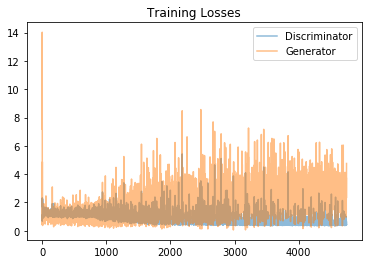

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()